# Bayesian Forecaster

#### Imports

In [105]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pickle

#### data setup

In [106]:
# importing data
experiment_type = "small"
data_directory = '../data/experiment_' + experiment_type + '/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (2,1, 0))

#reshaping and trimming
data = data.reshape(len(data),2*len(data[0]))
data_test = data[-365:,:]
data_val = data[-3*365:-365,:]
data_train = data[:-3*365,:]

diffs_test = np.diff(data_test, axis=0)
diffs_val = np.diff(data_val, axis=0)
diffs_train = np.diff(data_train, axis=0)

T,D = diffs_train.shape

# creating the dataframe
hospital_list = np.genfromtxt(data_directory + 'network_params/hospitals.txt', dtype=str, delimiter='\n', comments=None)
df_cols = np.array([[h + ' supply',h + ' demand'] for h in hospital_list]).reshape(D)
df_train = pd.DataFrame(diffs_train, columns=df_cols)

df_train

,Orange County supply,Orange County demand,Los Angeles supply,Los Angeles demand,Alta Bates supply,Alta Bates demand,Oakland supply,Oakland demand
0,-4.229776,0.755123,-2.867356,-1.366425,-0.637857,-0.303954,-0.588753,0.105098
1,-0.061322,1.770917,2.099036,-0.015776,0.466948,-0.003524,-0.008509,0.246496
2,-0.455538,4.533603,1.507943,3.460856,0.335440,0.769893,-0.063413,0.631038
3,-4.875466,1.772271,-3.985616,0.204697,-0.886622,0.045532,-0.678618,0.246691
4,0.161915,-1.874088,2.046008,-4.132274,0.455140,-0.919247,0.022536,-0.260865
...,...,...,...,...,...,...,...,...
1700,-3.109834,-2.768898,-5.122294,-2.040495,-1.139492,-0.453916,-0.432863,-0.385399
1701,-0.583132,-0.400013,-2.053151,0.855276,-0.456735,0.190256,-0.081168,-0.055681
1702,-3.893299,-3.811863,-6.094335,-3.293824,-1.355707,-0.732731,-0.541910,-0.530574
1703,5.139939,0.770655,4.905448,2.296107,1.091240,0.510789,0.715432,0.107265


#### constructing the BVAR model

In [3]:
def bvar_model(h,df,priors,draws=2000,tune=1000,chains=4,cores=4):
    coords = {
        "lags": np.arange(h)+1,
        "vars": df.columns.tolist(),
        "eqs": df.columns.tolist(),
        "time": [t for t in df.index[h:]]
    }

    with pm.Model(coords=coords) as model:
        # variable setup
        beta = pm.Normal(
            "beta",
            mu=priors["beta"]["mu"],
            sigma=priors["beta"]["sigma"],
            dims=("lags","eqs","vars")
        )
        alpha = pm.Normal(
            "alpha",
            mu=priors["alpha"]["mu"],
            sigma=priors["alpha"]["sigma"],
            dims=("eqs",)
        )
        data_obs = pm.Data(
            "data_obs",
            df.values[h:], 
            dims=("time","eqs"),
        )

        D = df.shape[1]

        # ar step
        ar = []
        for i in range(D):
            ar_i = pm.math.sum([
                pm.math.sum(beta[t,i] * df.values[h-(t+1):-(t+1)],axis=-1)
                for t in range(h)
            ],axis=0)
            ar.append(ar_i)

        mu = alpha + pm.math.stack(ar, axis=-1)
        sigma = pm.HalfNormal(
            "noise",
            sigma=priors["noise"]["sigma"],
            dims=["eqs"]
        )
        obs = pm.Normal(
            "obs",
            mu=mu,
            sigma=sigma,
            observed=data_obs,
            dims=["time","eqs"]
            )

        #sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            random_seed=420,
            target_accept=0.99,
            sample='numpyro',
            nuts={"max_treedepth":20}
        )
    return model,trace

In [4]:
h = 12
draws=1000
tune=6000
chains=4
cores=4

priors = {
    "beta": {"mu": 0.0, "sigma": 100.0},
    "alpha": {"mu": 0.0, "sigma": 100.0},
    "noise": {"sigma": 100.0}
}

model, trace = bvar_model(h, df_train, priors,draws=draws,tune=tune,chains=chains,cores=cores)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, noise]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 14575 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### looking at the model

In [5]:
az.summary(trace, var_names=["alpha", "beta","noise"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Orange County supply],0.065,0.055,-0.029,0.165,0.010,0.008,31.0,87.0,1.11
alpha[Orange County demand],0.073,0.055,-0.040,0.169,0.007,0.005,60.0,68.0,1.08
alpha[Los Angeles supply],0.091,0.073,-0.046,0.226,0.008,0.007,82.0,182.0,1.05
alpha[Los Angeles demand],0.078,0.081,-0.107,0.205,0.020,0.014,18.0,42.0,1.18
alpha[Alta Bates supply],0.023,0.016,-0.006,0.053,0.002,0.002,58.0,137.0,1.09
...,...,...,...,...,...,...,...,...,...
noise[Los Angeles demand],3.035,0.050,2.939,3.133,0.013,0.010,14.0,52.0,1.21
noise[Alta Bates supply],0.690,0.011,0.671,0.708,0.002,0.001,43.0,201.0,1.05
noise[Alta Bates demand],0.675,0.013,0.651,0.698,0.002,0.002,30.0,113.0,1.11
noise[Oakland supply],0.355,0.007,0.342,0.369,0.002,0.001,13.0,74.0,1.24


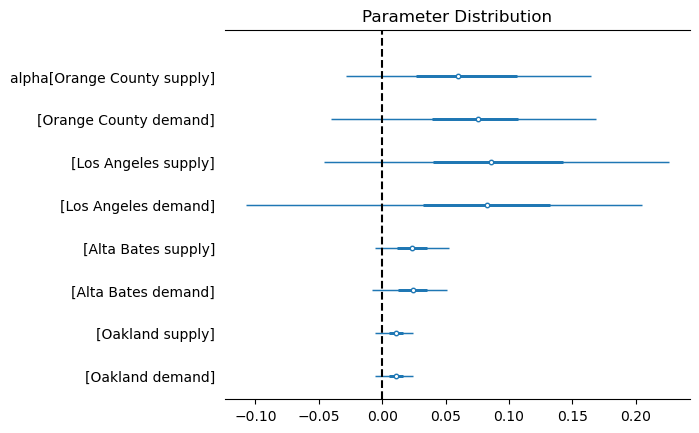

In [6]:
#fig, ax = plt.subplots(figsize=(20, 100))
az.plot_forest(trace, var_names=["alpha"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Parameter Distribution");

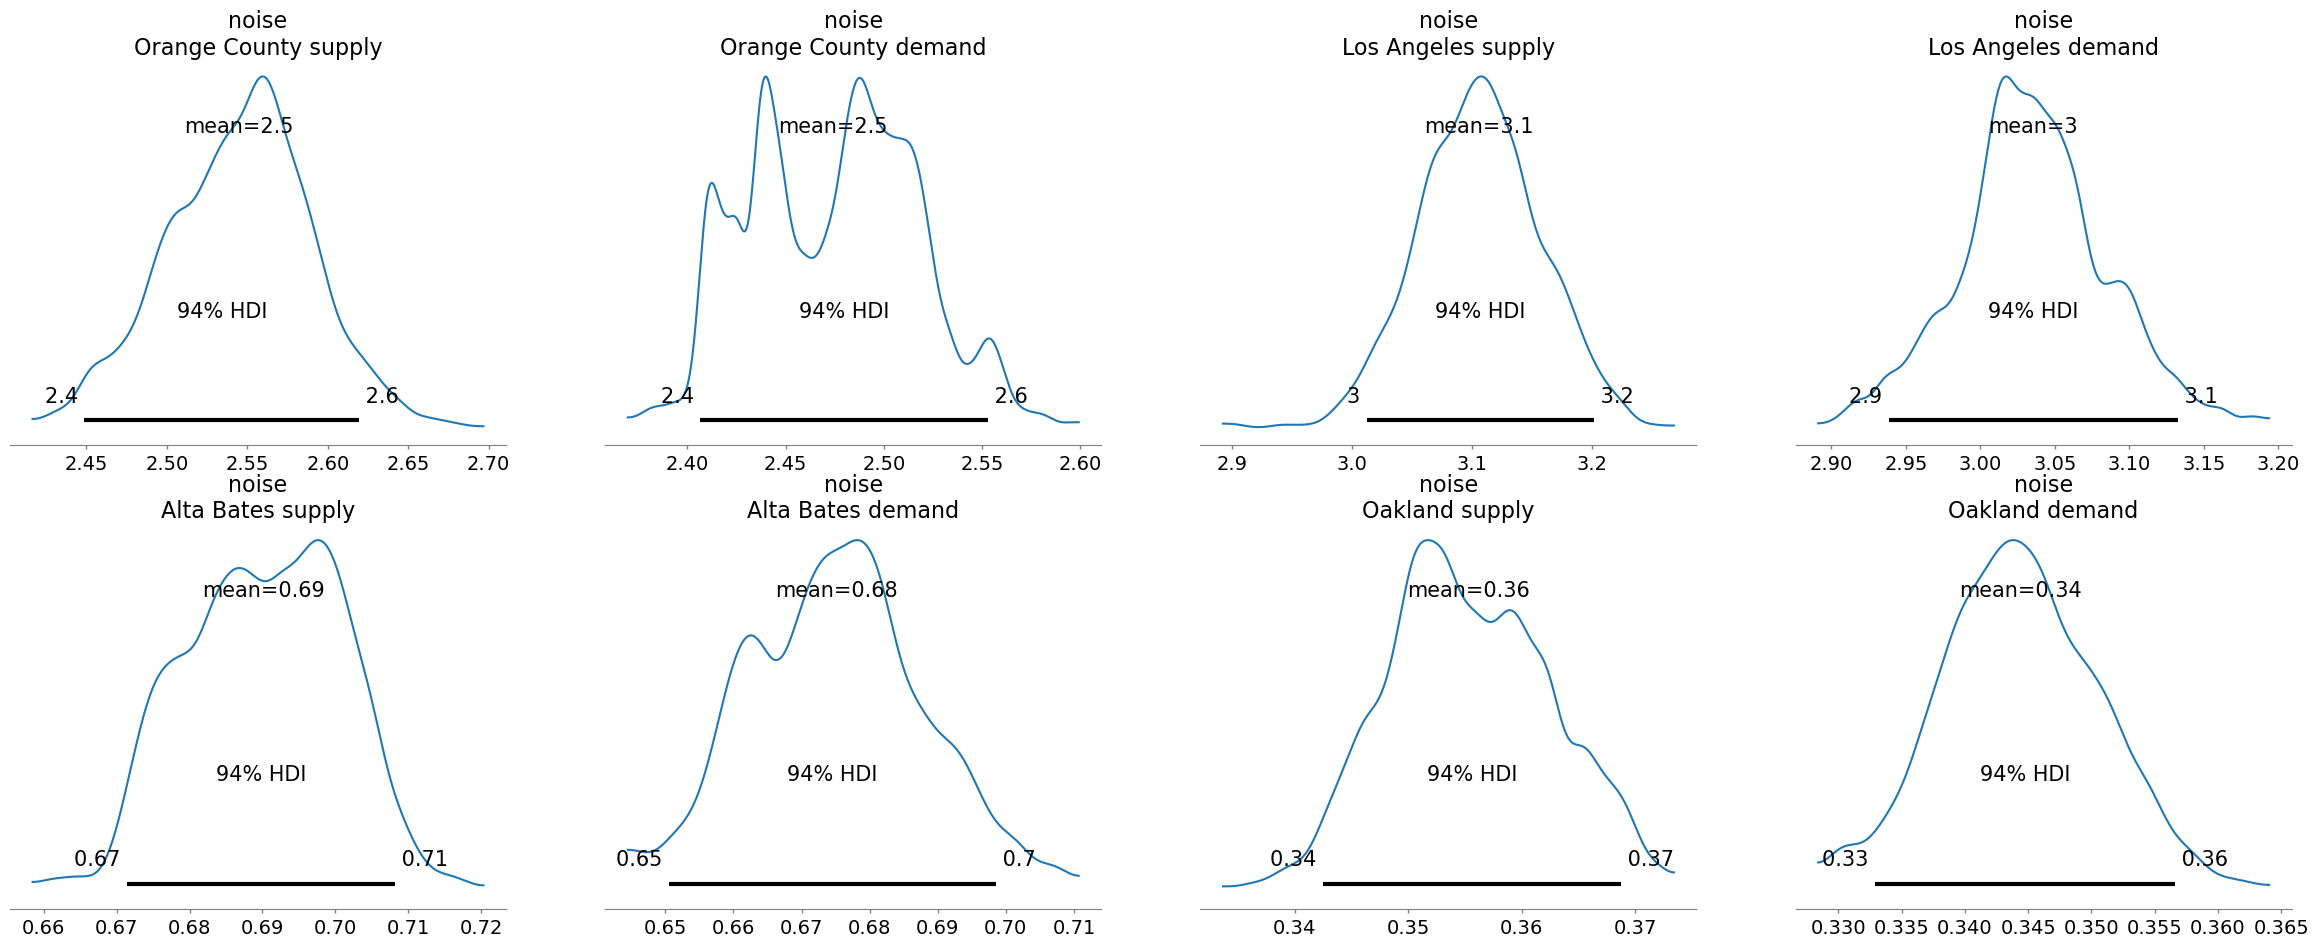

In [7]:
az.plot_posterior(trace, var_names=["noise"]);

#### forecasting

In [8]:
def _forecast(data,alpha,beta,noise,f):
    len_data = len(data)
    h = len(beta)
    data_forecast = np.zeros((data.shape[0]+f,data.shape[1]))
    data_forecast[:len_data] = data[:]

    for t in range(f):
        ar = []
        for n in range(data.shape[1]):
            ar_n = np.sum(beta[:,n]*data_forecast[len_data+t-h:len_data+t])
            ar.append(ar_n)
        mu = alpha + np.stack(ar,axis=-1)
        data_forecast[len_data+t] = np.random.normal(mu,noise)
    data_forecast[:-f-1] = np.nan
    return data_forecast

forecast = np.vectorize(
    _forecast,
    signature=("(T,D),(D),(H,D,D),(D)->(F,D)"),
    excluded=("f"),
)

In [41]:
size = 2000
sample_indices = np.random.randint(draws*chains,size=size)
post = trace.posterior.stack(sample=("chain","draw"))
alpha_draws = post["alpha"].values.T[sample_indices]
beta_draws = post["beta"].values.T[sample_indices].T
beta_draws = np.moveaxis(beta_draws,-1,0)
noise_draws = post["noise"].values.T[sample_indices]

alpha_avg=np.mean(alpha_draws,axis=0)
beta_avg=np.mean(beta_draws,axis=0)
noise_avg=np.mean(noise_draws,axis=0)

In [66]:
f=7
forecast_draws = forecast(diffs_train,alpha_draws,beta_draws,noise_draws,f=f)
forecast_draws_mean = _forecast(diffs_train,alpha_avg,beta_avg,noise_avg,f=f)

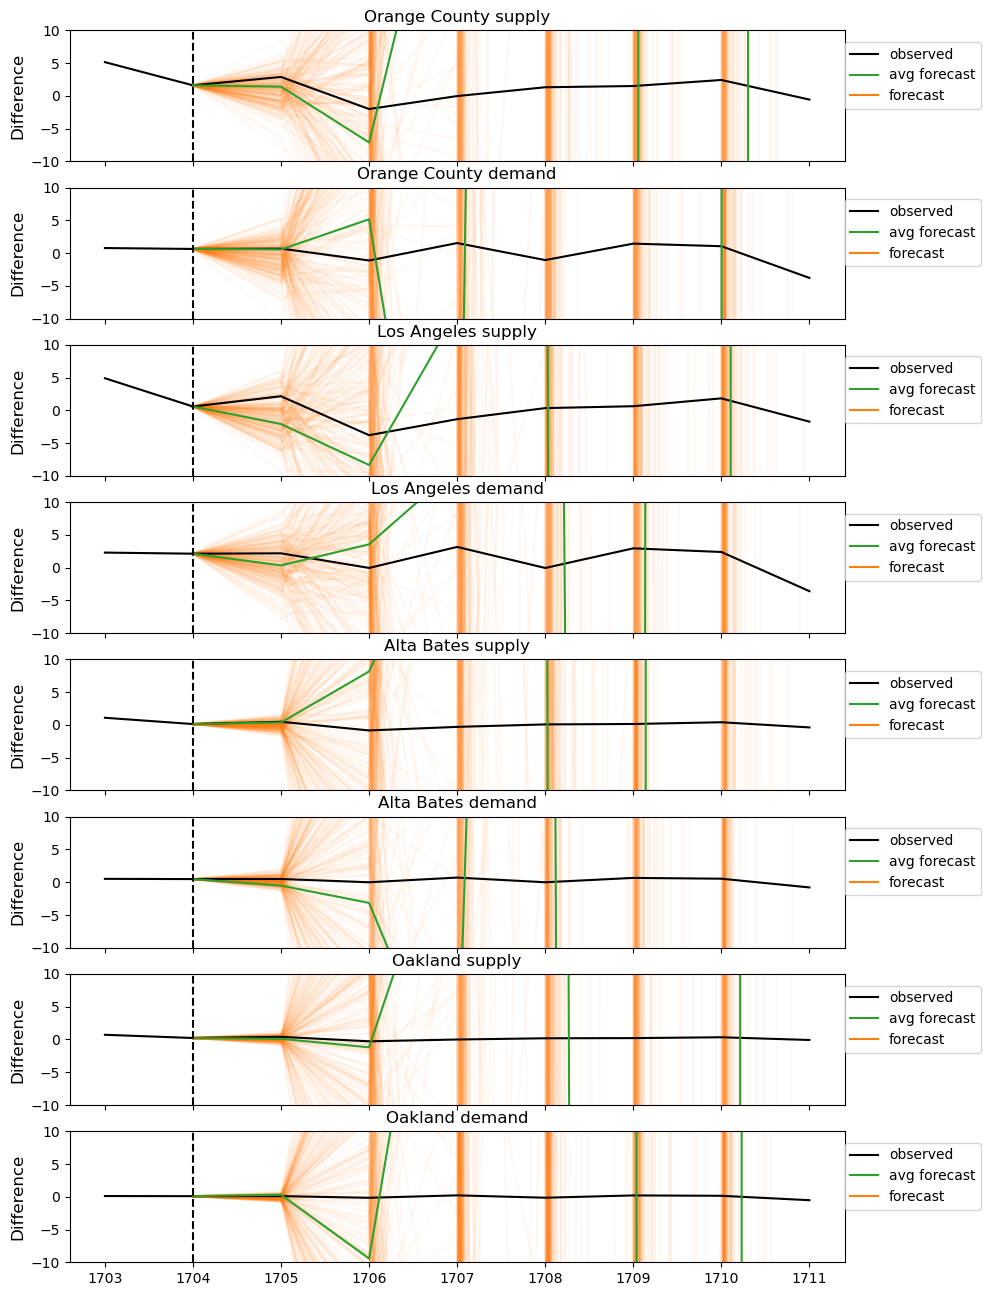

In [67]:
_, ax = plt.subplots(D, 1, sharex=True,figsize=(10,2*D))
times = np.arange(len(diffs_train)+f)
diff = np.diff(data, axis=0)
stagger = 1703

for n in range(D):
    ax[n].set_title(df_cols[n])

    for i in range(forecast_draws.shape[0]):
        if i%10==0:
            ax[n].plot(times[stagger:], forecast_draws[i,stagger:,n], color="C1", alpha=0.05)

    ax[n].set_ylim(-10, 10)
    ax[n].plot(times[stagger:],diff[stagger:len(diffs_train)+f,n], color="k", label="observed")
    ax[n].plot(times[stagger:], forecast_draws_mean[stagger:,n], color="C2",label="avg forecast")
    ax[n].plot([], color="C1", label="forecast")

for axi in ax:
    axi.axvline(len(times)-f-1, ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("Difference", fontsize=12)

In [13]:
trace.to_netcdf('trace.nc')

'trace.nc'

#### formatting functions for the shapes

In [68]:
def get_bayesian_forecast(trace,history,f,sample_size=2000):
    chains, draws = trace.posterior.sizes["chain"],trace.posterior.sizes["draw"]
    sample_indices = np.random.randint(draws*chains,size=size)
    post = trace.posterior.stack(sample=("chain","draw"))
    alpha_draws = post["alpha"].values.T[sample_indices]
    beta_draws = post["beta"].values.T[sample_indices].T
    beta_draws = np.moveaxis(beta_draws,-1,0)
    noise_draws = post["noise"].values.T[sample_indices]

    alpha_avg=np.median(alpha_draws,axis=0)
    beta_avg=np.median(beta_draws,axis=0)
    noise_avg=np.median(noise_draws,axis=0)

    N,h,_ = history.shape
    history_resh = history.transpose(1,0,2).reshape(h,2*N)
    history_resh_diff = np.diff(history_resh,axis=0)

    forecast_avg = _forecast(history_resh_diff,alpha_avg,beta_avg,noise_avg,f=f)
    forecast_avg = forecast_avg[-f:,:]
    forecast_avg = history_resh[-1,:] + np.cumsum(forecast_avg,axis=0)
    return forecast_avg.reshape(forecast_avg.shape[0],forecast_avg.shape[1]//2,2).transpose(1,0,2)

In [72]:
history = data_train[-h-1:,:]
history = history.reshape(h+1,history.shape[1]//2,2).transpose(1,0,2)

test = get_bayesian_forecast(trace,history,f=f,sample_size=2000)

In [73]:
test[0]

array([[ 3.06764989e+02,  3.61082240e+02],
       [ 4.04027859e+02,  4.98507522e+02],
       [-4.47895233e+02,  2.23950005e+02],
       [-8.11968765e+03, -1.91715324e+04],
       [ 1.13685068e+05, -2.67980201e+04],
       [ 7.90689231e+05,  2.57857587e+06],
       [-1.58495725e+07,  3.00109924e+06]])

In [74]:
data_val[:f,0]

array([304.81392269, 302.79674543, 302.75799699, 304.06401472,
       305.55623157, 307.9703664 , 307.3968198 ])

In [54]:
az.to_netcdf(trace, 'trace.nc')

'trace.nc'

#### model

In [65]:
bvar_model = az.from_netcdf('trace.nc')

0.20.0


array([[[306.2830171 , 360.28232896],
        [412.56685648, 462.9565952 ]],

       [[415.10508381, 372.72093453],
        [578.89158994, 349.65574923]],

       [[106.63436209,  99.46080057],
        [ 69.55499015, 145.54381983]],

       [[ 36.57700772,  42.19132835],
        [ 51.20687491,   4.02603536]]])

#### validating model

In [75]:
from sklearn.metrics import mean_squared_error as mse_metric

In [103]:
def get_mse(forecast, true_vals):
    N, f , _ = forecast.shape
    forecast = forecast.reshape(N, f * 2)
    true_vals = true_vals.reshape(N, f * 2)
    
    return mse_metric(forecast, true_vals)

def get_BVAR_forecast_rmse(bvar_model, hists, futures):
    _, _, f, _ = futures.shape
    forecasts = np.array([get_bayesian_forecast(bvar_model, hist,f) for hist in hists])
    mse = np.mean([get_mse(forecasts[i], futures[i]) for i in range(len(futures))])
    return np.sqrt(mse)

def data_slice(data, h, f):
    T = h + f
    samples = np.array([data[:,t:t + T,:] for t in range(len(data[0]) - T + 1)])
    return samples[:, :, :h, :], samples[:, : , h:, :]

In [111]:
f=1
data_val_resh = data_val.reshape(data_val.shape[0],data_val.shape[1]//2,2).transpose(1,0,2)
hist_val, future_val = data_slice(data_val_resh, h = h+1, f = f)
print(get_BVAR_forecast_rmse(bvar_model, hist_val, future_val))

8.067007062678602
